## Finding
* 2019 misses data on_1b, on_2b, and on_3b
* incorrect ball and strike counts in 2019
* 2019 data can't be used
* Use TimeSeriesSplit (iterators) can be used in cv=
* RF => set max_depth

## EDA
* More balls less fastball 'b_count'
* 2 strikes less fastball 's_2'
* Out no effect
* tie=> more fastball; ahead/behind => less fastball 'ahead' 'behind'
* Left Batter => more fastball
* Warm => less fastball
* Last play Error => less fastball
* Last play Out => more fastball
* Last play Homerun/Triple/Douple => less fastball 'last_pa_homerun' 'last_pa_double_triple'
* Last Pitch result 'last_pitch'
* Last pitch type/fastball => less fastball
* More innings less fastball
* on_1b no effect
* last play pitch a lot => fastball

## Completed
* Data assembling
* SQL database
* Data Cleaning
* EDA

## To do
* split
* modeling



In [11]:
import pandas as pd
import numpy as np

In [176]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [364]:
import warnings
warnings.filterwarnings('ignore')

In [1671]:
# feature engineering
# type_confidence, code 
df = pd.read_sql("""SELECT pitch_type, start_speed, zone, code, type, b_score, p_score, ab_id, pitch_num,
                    b_count, s_count, outs, on_1b, on_2b, on_3b, event, inning, stand, top, 
                    weather, start_time, year                    
                    FROM scherzer
                    WHERE year != 2019;""",'sqlite:///mlb_2015_2019.db')

In [1672]:
#df['xxxx'] = df['xxxx'].apply(lambda x: 'xx' if x == 'xx' else 'xx')
df['top'].replace(['FALSE','TRUE'],[0,1],inplace=True)
df['top'] = df['top'].astype('int')
df['stand'].replace(['R','L'],[0,1],inplace=True)
df.rename(columns={"stand": "left_batter"},inplace=True)
df['start_time'] = pd.to_timedelta(df['start_time']+':00')
df['day_game'] = (df['start_time'] < '16:30:00').astype('int')
#df['fastball'] = df['pitch_type'].isin(['FF','FT','FC']).astype('int')
df.insert(1, column='fastball', value = df['pitch_type'].isin(['FF','FT','FC']).astype('int'))
df = pd.concat([df,pd.get_dummies(df['b_count'],prefix='b',drop_first=False)], axis=1)
df = pd.concat([df,pd.get_dummies(df['s_count'],prefix='s',drop_first=False)], axis=1)
df = pd.concat([df,pd.get_dummies(df['outs'],prefix='o',drop_first=False)], axis=1)
df['after_4_inning'] =  (df['inning'] > 3).astype('int')
df['after_5_inning'] =  (df['inning'] > 4).astype('int')
df['first2ball'] = (df['pitch_num'] < 3).astype('int')
df['abs_diff'] = abs(df['p_score'] - df['b_score'])
df['diff'] = df['p_score'] - df['b_score']
df['tie'] = (df['p_score'] == df['b_score']).astype('int')
df['ahead'] = (df['p_score'] - df['b_score'] > 0).astype('int')
df['behind'] = (df['p_score'] - df['b_score'] < 0).astype('int')
df['tempature'] = df['weather'].apply(lambda x : x[:2]).astype('int') #min 45 max 95
df['more_than_70'] = (df['tempature'] > 70).astype('int')
df['last_pitch_type'] = df['pitch_type'].shift(1)
df.loc[0,'last_pitch_type'] = 'FF'
df['last_fastball'] = df['fastball'].shift(1)
df.loc[0,'last_fastball'] = 1
df['last_fastball'] = df['last_fastball'].astype('int')
df['last_code'] = df['code'].shift(1)
df.loc[0,'last_code'] = 'X'
df['last_type'] = df['type'].shift(1)
df.loc[0,'last_type'] = 'X'
df['last_b'] = df['last_type'].isin(['B']).astype('int')
df['last_s'] = df['last_type'].isin(['S']).astype('int')
df['last_inplay'] = df['last_type'].isin(['X']).astype('int')
df['last_contact'] = df['last_code'].isin(['F','T','L','R','X','D','E']).astype('int')
df['last_pitch'] = df['last_code'].map({'B':'B','*B':'B','S':'S','C':'S','F':'S','T':'S','L':'S',
                                       'I':'B','W':'S','M':'S','P':'B','Q':'S','R':'S','X':'X',
                                       'D':'H','E':'R','H':'B','V':'B'})
df_pa = pd.read_csv('data/atbats.csv')
df_pa['last_pa'] = df_pa['event'].shift(1)
df_pa.loc[0,'last_pa'] = 'Strikeout'
df_pa = pd.merge(df_pa[df_pa['pitcher_id'] ==453286], 
                 df.drop_duplicates(subset=['ab_id'], keep='last')[['pitch_num','ab_id']]
                 , on = 'ab_id')
df_pa['last_num'] = df_pa['pitch_num'].shift(1)
df_pa.loc[0,'last_num'] = 4 #mean
df_pa['last_num'] = df_pa['last_num'].astype('int')
df_pa['game_pitch'] = df_pa.groupby(['g_id']).cumsum().reset_index()['last_num'] - 4
df = pd.merge(df ,df_pa[['ab_id','last_pa','last_num','game_pitch']], on = 'ab_id')
df['last_over_8'] = (df['last_num'] > 8).astype('int')
df['over_30_pitches'] = (df['game_pitch'] > 30).astype('int')
df['last_pa_homerun'] = df['last_pa'].isin(['Home Run']).astype('int')
df['last_pa_double_triple'] = df['last_pa'].isin(['Double','Triple']).astype('int')
df['last_pa_long'] = df['last_pa'].isin(['Double','Triple','Home Run']).astype('int')
df['last_pa_so'] = df['last_pa'].isin(['Strikeout']).astype('int')
df['last_pa_bb'] = df['last_pa'].isin(['Walk','Hit By Pitch','Intent Walk']).astype('int')
df['last_pa_dp'] = df['last_pa'].isin(['Grounded Into DP','Double Play','Strikeout - DP','Sac Fly DP',
                                      'Sacrifice Bunt DP']).astype('int')
df['last_pa_out'] = df['last_pa'].isin(['Strikeout','Groundout','Flyout','Lineout','Pop Out','Forceout',
                                        'Runner Out','Bunt Groundout','Fielders Choice Out','Bunt Pop Out',
                                        'Fielders Choice','Batter Interference','Bunt Lineout',
                                        'Grounded Into DP','Double Play','Strikeout - DP','Sac Fly DP',
                                        'Sacrifice Bunt DP']).astype('int')


#df.to_csv('data/scherzer_features.csv')

In [1673]:
#******must Run***
#Split
tscv = TimeSeriesSplit(n_splits=5)
df_clean = df.dropna(how='any')
for train_index, test_index in tscv.split(df_clean):
    df_train, df_test = df_clean.iloc[train_index,], df_clean.iloc[test_index]
#df_train.to_csv('data/scherzer_train.csv')

In [365]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11212 entries, 0 to 11277
Data columns (total 54 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   pitch_type             11212 non-null  object         
 1   fastball               11212 non-null  int64          
 2   start_speed            11212 non-null  float64        
 3   zone                   11212 non-null  float64        
 4   code                   11212 non-null  object         
 5   type                   11212 non-null  object         
 6   b_score                11212 non-null  int64          
 7   p_score                11212 non-null  int64          
 8   ab_id                  11212 non-null  int64          
 9   pitch_num              11212 non-null  int64          
 10  b_count                11212 non-null  int64          
 11  s_count                11212 non-null  int64          
 12  outs                   11212 non-null  int64  

In [440]:
df.columns

Index(['pitch_type', 'fastball', 'start_speed', 'zone', 'code', 'type',
       'b_score', 'p_score', 'ab_id', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'event', 'inning', 'left_batter',
       'top', 'weather', 'start_time', 'year', 'day_game', 'b_1', 'b_2', 'b_3',
       's_1', 's_2', 'o_1', 'o_2', 'after_4_inning', 'diff', 'tie', 'ahead',
       'behind', 'tempature', 'more_than_70', 'last_pitch_type',
       'last_fastball', 'last_code', 'last_type', 'last_b', 'last_s',
       'last_inplay', 'last_contact', 'last_pitch', 'last_pa',
       'last_pa_homerun', 'last_pa_double_triple', 'last_pa_so', 'last_pa_bb',
       'last_pa_dp', 'last_pa_out'],
      dtype='object')

In [1675]:
sns.pairplot(df_train, hue='fastball')

KeyboardInterrupt: 

## Baseline Model

In [1356]:
X = df_train[['b_count', 's_count', 'outs', 'on_1b', 'on_2b','on_3b','inning', 'left_batter', 'top','day_game']]
y = df_train['fastball']

In [435]:
#y.mean()
metrics.accuracy_score(y, [1]*len(y))

0.5871387798787014

In [483]:
dummy_cv = []
for train_index, test_index in tscv.split(X):
    dummy_cv.append(y.iloc[test_index].mean())
print(dummy_cv)
np.mean(dummy_cv)

[0.6193790149892934, 0.5701284796573876, 0.5722698072805139, 0.5519271948608137, 0.6145610278372591]


0.5856531049250535

In [437]:
log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.6027470567249376

In [438]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.658913
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11201
Method:                           MLE   Df Model:                           10
Date:                Fri, 22 Oct 2021   Pseudo R-squ.:                 0.02798
Time:                        14:57:03   Log-Likelihood:                -7387.7
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                 3.697e-85
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.5856      0.064      9.102      0.000       0.460       0.712
b_count         0.1990      0.023      8.501      0.000       0.153       0.245
s_count        -0.3217      0.025    -12.668      0.000      -0.371      -0.272
outs            0.0020      0.025      0.079      0.937      -0.047       0.051
on_1b           0.0152      0.048      0.317      0.751      -0.079       0.109
on_2b          -0.1884      0.060     -3.167      0.002      -0.305      -0.072
on_3b          -0.1338      0.086     -1.557      0.119      -0.302       0.035
inning         -0.0746      0.009     -7.997      0.000      -0.093      -0.056
left_batter     0.4361      0.039     11.079      0.000       0.359       0.513
top             0.0026      0.039      0.066      0.948      -0.074       0.079
day_game        0.0624      0.042      1.499      0.134      -0.019       0.144
===============================================================================
"""

In [1360]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.60599572 0.59475375 0.59154176 0.56852248 0.61456103]


0.5950749464668095

## multi-class

In [118]:
X = df_train[['b_count', 's_count', 'outs', 'on_1b', 'on_2b','on_3b','inning', 'left_batter', 'top','day_game']]
y = df_train['pitch_type']

In [119]:
metrics.accuracy_score(y, ['FF']*len(y))

0.5338922582946842

In [120]:
log_reg = LogisticRegression(multi_class='ovr')
log_reg.fit(X,y)
log_reg.score(X,y)

0.5371922939707456

In [122]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.58029979 0.55192719 0.54443255 0.44486081 0.49518201]


0.523340471092077

## Feature Selection

In [545]:
df_train.columns

Index(['pitch_type', 'fastball', 'start_speed', 'zone', 'code', 'type',
       'b_score', 'p_score', 'ab_id', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'event', 'inning', 'left_batter',
       'top', 'weather', 'start_time', 'year', 'day_game', 'b_1', 'b_2', 'b_3',
       's_1', 's_2', 'o_1', 'o_2', 'after_4_inning', 'abs_diff', 'diff', 'tie',
       'ahead', 'behind', 'tempature', 'more_than_70', 'last_pitch_type',
       'last_fastball', 'last_code', 'last_type', 'last_b', 'last_s',
       'last_inplay', 'last_contact', 'last_pitch', 'last_pa',
       'last_pa_homerun', 'last_pa_double_triple', 'last_pa_so', 'last_pa_bb',
       'last_pa_dp', 'last_pa_out'],
      dtype='object')

In [564]:
#'b_count', 's_count','outs', 
#'last_inplay','tie', 'abs_diff','after_4_inning', 'more_than_70',
X = df_train[['pitch_num', 
              'on_1b', 'on_2b', 'on_3b', 'inning', 'left_batter','after_5_inning',
              'top', 'day_game', 'b_1', 'b_2', 'b_3','s_1', 's_2', 'o_1', 'o_2',
                'diff',  'tempature',
              'last_fastball', 'last_b', 'last_s', 'ahead','behind',
              'last_contact','last_pa_homerun', 'last_pa_double_triple', 
              'last_pa_so', 'last_pa_bb','last_pa_dp', 'last_pa_out']]
y = df_train['fastball']

In [565]:
log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.6171958615768819

In [566]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.650747
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11181
Method:                           MLE   Df Model:                           30
Date:                Fri, 22 Oct 2021   Pseudo R-squ.:                 0.04003
Time:                        19:02:33   Log-Likelihood:                -7296.2
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                5.148e-109
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.3443      0.202      6.664      0.000       0.949       1.740
pitch_num                -0.0996      0.044     -2.264      0.024      -0.186      -0.013
on_1b                    -0.0131      0.070     -0.187      0.852      -0.150       0.124
on_2b                    -0.2251      0.072     -3.110      0.002      -0.367      -0.083
on_3b                    -0.1470      0.089     -1.655      0.098      -0.321       0.027
inning                   -0.0502      0.018     -2.770      0.006      -0.086      -0.015
left_batter               0.4676      0.040     11.666      0.000       0.389       0.546
after_5_inning           -0.1358      0.075     -1.809      0.070      -0.283       0.011
top                       0.0095      0.042      0.226      0.821      -0.073       0.092
day_game                  0.0796      0.042      1.891      0.059      -0.003       0.162
b_1                       0.3327      0.078      4.253      0.000       0.179       0.486
b_2                       0.7720      0.125      6.192      0.000       0.528       1.016
b_3                       1.4724      0.190      7.732      0.000       1.099       1.846
s_1                      -0.0205      0.073     -0.282      0.778      -0.163       0.122
s_2                      -0.4868      0.116     -4.193      0.000      -0.714      -0.259
o_1                       0.0264      0.049      0.535      0.593      -0.070       0.123
o_2                      -0.0053      0.051     -0.103      0.918      -0.106       0.095
diff                      0.0228      0.013      1.819      0.069      -0.002       0.047
tempature                -0.0033      0.002     -1.669      0.095      -0.007       0.001
last_fastball            -0.3169      0.041     -7.689      0.000      -0.398      -0.236
last_b                   -0.4956      0.114     -4.348      0.000      -0.719      -0.272
last_s                   -0.0935      0.091     -1.027      0.304      -0.272       0.085
ahead                    -0.1435      0.061     -2.363      0.018      -0.262      -0.024
behind                   -0.0160      0.062     -0.259      0.796      -0.138       0.105
last_contact             -0.1645      0.063     -2.632      0.008      -0.287      -0.042
last_pa_homerun          -0.3165      0.147     -2.151      0.031      -0.605      -0.028
last_pa_double_triple     0.0257      0.131      0.197      0.844      -0.231       0.282
last_pa_so               -0.0149      0.049     -0.305      0.761      -0.111       0.081
last_pa_bb                0.0346      0.102      0.338      0.736      -0.166       0.235
last_pa_dp               -0.0755      0.144     -0.526      0.599      -0.357       0.206
last_pa_out              -0.0524      0.088     -0.599      0.549      -0.224       0.119
=========================================================================================
"""

In [567]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.61509636 0.60171306 0.61509636 0.58940043 0.62205567]


0.6086723768736617

In [665]:
#'b_count', 's_count','outs', 
#'last_inplay','tie', 'abs_diff','after_5_inning', 'more_than_70',
# p-value high: 'o_2','last_pa_double_triple', 'top', 'behind','last_pa_so','on_1b', 'first2ball',
X = df_train[['pitch_num', 
              'on_2b', 'on_3b', 'inning', 'left_batter','after_4_inning',
              'day_game', 'b_1', 'b_2', 'b_3','s_1', 's_2', 'o_1', 
                'diff',  'tempature',
              'last_fastball', 'last_b', 'last_s', 'ahead',
              'last_contact','last_pa_homerun', 
               'last_pa_bb','last_pa_dp', 'last_pa_out']]
y = df_train['fastball']

In [666]:
log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.617374241883696

In [667]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.650764
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11187
Method:                           MLE   Df Model:                           24
Date:                Fri, 22 Oct 2021   Pseudo R-squ.:                 0.04000
Time:                        19:18:18   Log-Likelihood:                -7296.4
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                4.770e-113
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.3325      0.187      7.121      0.000       0.966       1.699
pitch_num          -0.0990      0.044     -2.252      0.024      -0.185      -0.013
on_2b              -0.2194      0.066     -3.328      0.001      -0.349      -0.090
on_3b              -0.1490      0.088     -1.702      0.089      -0.321       0.023
inning             -0.0503      0.018     -2.799      0.005      -0.086      -0.015
left_batter         0.4671      0.040     11.695      0.000       0.389       0.545
after_4_inning     -0.1367      0.075     -1.827      0.068      -0.283       0.010
day_game            0.0794      0.042      1.890      0.059      -0.003       0.162
b_1                 0.3327      0.078      4.259      0.000       0.180       0.486
b_2                 0.7713      0.125      6.193      0.000       0.527       1.015
b_3                 1.4703      0.190      7.730      0.000       1.098       1.843
s_1                -0.0188      0.072     -0.260      0.795      -0.160       0.123
s_2                -0.4857      0.116     -4.196      0.000      -0.713      -0.259
o_1                 0.0289      0.042      0.692      0.489      -0.053       0.111
diff                0.0238      0.012      2.044      0.041       0.001       0.047
tempature          -0.0032      0.002     -1.648      0.099      -0.007       0.001
last_fastball      -0.3164      0.041     -7.680      0.000      -0.397      -0.236
last_b             -0.5004      0.113     -4.434      0.000      -0.722      -0.279
last_s             -0.0996      0.089     -1.122      0.262      -0.274       0.074
ahead              -0.1414      0.059     -2.385      0.017      -0.258      -0.025
last_contact       -0.1646      0.062     -2.634      0.008      -0.287      -0.042
last_pa_homerun    -0.3176      0.133     -2.393      0.017      -0.578      -0.057
last_pa_bb          0.0237      0.096      0.246      0.805      -0.165       0.212
last_pa_dp         -0.0665      0.142     -0.470      0.639      -0.344       0.211
last_pa_out        -0.0569      0.063     -0.901      0.368      -0.181       0.067
===================================================================================
"""

In [668]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.61456103 0.60224839 0.61295503 0.5872591  0.62687366]


0.6087794432548179

In [444]:
X = df_train[['b_count', 's_2', 'on_2b', 'on_3b', 'inning', 'left_batter',
       'day_game', 'ahead', 'behind', 'tempature','last_fastball','last_b','last_s', 
       'last_pa_homerun', 'last_pa_double_triple', 'last_pa_bb','last_pa_out']]
y = df_train['fastball']

In [445]:
log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.6167499108098466

In [446]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.652547
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11194
Method:                           MLE   Df Model:                           17
Date:                Fri, 22 Oct 2021   Pseudo R-squ.:                 0.03737
Time:                        15:17:24   Log-Likelihood:                -7316.4
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                7.913e-110
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.0989      0.176      6.235      0.000       0.753       1.444
b_count                   0.3106      0.029     10.871      0.000       0.255       0.367
s_2                      -0.6899      0.048    -14.420      0.000      -0.784      -0.596
on_2b                    -0.2279      0.071     -3.200      0.001      -0.367      -0.088
on_3b                    -0.1551      0.088     -1.771      0.077      -0.327       0.017
inning                   -0.0749      0.010     -7.238      0.000      -0.095      -0.055
left_batter               0.4587      0.040     11.519      0.000       0.381       0.537
day_game                  0.0733      0.042      1.747      0.081      -0.009       0.156
ahead                    -0.0895      0.050     -1.785      0.074      -0.188       0.009
behind                   -0.0657      0.057     -1.147      0.251      -0.178       0.047
tempature                -0.0031      0.002     -1.611      0.107      -0.007       0.001
last_fastball            -0.3278      0.041     -8.062      0.000      -0.407      -0.248
last_b                   -0.4097      0.074     -5.560      0.000      -0.554      -0.265
last_s                   -0.0833      0.062     -1.349      0.177      -0.204       0.038
last_pa_homerun          -0.3011      0.135     -2.231      0.026      -0.566      -0.037
last_pa_double_triple     0.0404      0.117      0.347      0.729      -0.188       0.269
last_pa_bb                0.0533      0.101      0.528      0.597      -0.144       0.251
last_pa_out              -0.0344      0.068     -0.509      0.611      -0.167       0.098
=========================================================================================
"""

In [447]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.60653105 0.60224839 0.60974304 0.58029979 0.62794433]


0.6053533190578159

In [123]:
X = df_train[['b_count', 's_2', 'on_2b', 'on_3b', 'inning', 'left_batter',
       'day_game', 'ahead', 'behind', 'tempature','last_fastball','last_b','last_s', 'last_pa_homerun']]
y = df_train['fastball']

log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.615947199429183

In [124]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.652610
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11197
Method:                           MLE   Df Model:                           14
Date:                Thu, 21 Oct 2021   Pseudo R-squ.:                 0.03728
Time:                        22:29:08   Log-Likelihood:                -7317.1
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                6.364e-112
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0726      0.166      6.478      0.000       0.748       1.397
b_count             0.3085      0.028     10.851      0.000       0.253       0.364
s_2                -0.6882      0.048    -14.397      0.000      -0.782      -0.594
on_2b              -0.1925      0.059     -3.242      0.001      -0.309      -0.076
on_3b              -0.1397      0.086     -1.630      0.103      -0.308       0.028
inning             -0.0748      0.010     -7.237      0.000      -0.095      -0.055
left_batter         0.4556      0.040     11.473      0.000       0.378       0.533
day_game            0.0731      0.042      1.743      0.081      -0.009       0.155
ahead              -0.0919      0.050     -1.834      0.067      -0.190       0.006
behind             -0.0650      0.057     -1.134      0.257      -0.177       0.047
tempature          -0.0031      0.002     -1.610      0.108      -0.007       0.001
last_fastball      -0.3268      0.041     -8.041      0.000      -0.407      -0.247
last_b             -0.4031      0.072     -5.582      0.000      -0.545      -0.262
last_s             -0.0831      0.061     -1.364      0.173      -0.203       0.036
last_pa_homerun    -0.2752      0.121     -2.273      0.023      -0.512      -0.038
===================================================================================
"""

In [125]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.60492505 0.60171306 0.60920771 0.57976445 0.62955032]


0.6050321199143469

In [643]:
X = df_train[['left_batter','top', 'day_game', 'b_1', 'b_2', 'b_3',
              's_1', 's_2', 'o_1', 'o_2', 'after_4_inning', 'ahead','behind', 'more_than_70',
              'last_fastball', 'last_b', 'last_s','last_inplay', 'last_contact', 
              'last_pa_homerun', 'last_pa_double_triple', 'last_pa_so', 'last_pa_bb','last_pa_dp', 'last_pa_out']]
y = df_train['fastball']

log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.6198715661790938

In [644]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.651932
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11187
Method:                           MLE   Df Model:                           24
Date:                Fri, 22 Oct 2021   Pseudo R-squ.:                 0.03828
Time:                        19:16:31   Log-Likelihood:                -7309.5
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                1.419e-107
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.5294   2.39e+06   2.21e-07      1.000   -4.68e+06    4.68e+06
left_batter               0.4665      0.040     11.675      0.000       0.388       0.545
top                       0.0087      0.042      0.208      0.835      -0.074       0.091
day_game                  0.0854      0.042      2.029      0.042       0.003       0.168
b_1                       0.2271      0.061      3.739      0.000       0.108       0.346
b_2                       0.5529      0.073      7.527      0.000       0.409       0.697
b_3                       1.1329      0.103     10.974      0.000       0.931       1.335
s_1                      -0.1167      0.060     -1.929      0.054      -0.235       0.002
s_2                      -0.7144      0.065    -11.065      0.000      -0.841      -0.588
o_1                       0.0141      0.049      0.290      0.772      -0.081       0.109
o_2                      -0.0386      0.049     -0.786      0.432      -0.135       0.058
after_4_inning           -0.2992      0.043     -6.898      0.000      -0.384      -0.214
ahead                    -0.1013      0.050     -2.029      0.042      -0.199      -0.003
behind                   -0.0691      0.057     -1.203      0.229      -0.182       0.043
more_than_70             -0.0750      0.046     -1.623      0.105      -0.166       0.016
last_fastball            -0.3041      0.041     -7.406      0.000      -0.385      -0.224
last_b                   -0.1299   2.39e+06  -5.43e-08      1.000   -4.68e+06    4.68e+06
last_s                    0.2675   2.39e+06   1.12e-07      1.000   -4.68e+06    4.68e+06
last_inplay               0.3918   2.39e+06   1.64e-07      1.000   -4.68e+06    4.68e+06
last_contact             -0.2029      0.060     -3.388      0.001      -0.320      -0.086
last_pa_homerun          -0.2350      0.133     -1.762      0.078      -0.496       0.026
last_pa_double_triple    -0.1236      0.108     -1.149      0.251      -0.335       0.087
last_pa_so               -0.0253      0.049     -0.519      0.604      -0.121       0.070
last_pa_bb                0.0258      0.101      0.255      0.799      -0.173       0.224
last_pa_dp               -0.0627      0.143     -0.438      0.661      -0.343       0.218
last_pa_out               0.0142      0.068      0.209      0.834      -0.119       0.148
=========================================================================================
"""

In [645]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.61830835 0.60492505 0.61188437 0.58458244 0.62687366]


0.6093147751605995

## best logistic regression features

In [1630]:
X = df_train[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','last_pa_out',
              's_1', 's_2', 'after_4_inning', 'last_contact','day_game', 'last_pa_so','ahead',
              'last_pa_long']]
y = df_train['fastball']

log_reg = LogisticRegression(penalty='none')
log_reg.fit(X,y)
log_reg.score(X,y)

0.6185337138779878

In [1631]:
logreg = sm.Logit(y, sm.add_constant(X))
logreg = logreg.fit()
logreg.summary()

Optimization terminated successfully.
         Current function value: 0.652297
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               fastball   No. Observations:                11212
Model:                          Logit   Df Residuals:                    11196
Method:                           MLE   Df Model:                           15
Date:                Sun, 24 Oct 2021   Pseudo R-squ.:                 0.03774
Time:                        22:22:29   Log-Likelihood:                -7313.6
converged:                       True   LL-Null:                       -7600.4
Covariance Type:            nonrobust   LLR p-value:                1.335e-112
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7615      0.078      9.725      0.000       0.608       0.915
left_batter        0.4668      0.040     11.718      0.000       0.389       0.545
b_1                0.2067      0.059      3.497      0.000       0.091       0.323
b_2                0.5362      0.073      7.374      0.000       0.394       0.679
b_3                1.1209      0.103     10.906      0.000       0.919       1.322
last_b            -0.3913      0.065     -5.981      0.000      -0.520      -0.263
last_fastball     -0.3060      0.041     -7.483      0.000      -0.386      -0.226
last_pa_out        0.0121      0.057      0.213      0.831      -0.099       0.123
s_1               -0.1552      0.053     -2.912      0.004      -0.260      -0.051
s_2               -0.7593      0.055    -13.897      0.000      -0.866      -0.652
after_4_inning    -0.3118      0.043     -7.320      0.000      -0.395      -0.228
last_contact      -0.1611      0.051     -3.143      0.002      -0.262      -0.061
day_game           0.0779      0.042      1.859      0.063      -0.004       0.160
last_pa_so        -0.0394      0.047     -0.842      0.400      -0.131       0.052
ahead             -0.0607      0.042     -1.436      0.151      -0.144       0.022
last_pa_long      -0.1712      0.086     -1.999      0.046      -0.339      -0.003
==================================================================================
"""

In [1632]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.63008565 0.60224839 0.62205567 0.58672377 0.62740899]


0.6137044967880085

In [1633]:
metrics.accuracy_score(y, log_reg.predict_proba(X)[:,1]>0.467)

0.6179985729575455

## Logistic - pitch type

In [1637]:
X = df_train[['b_count', 's_2', 'on_2b', 'on_3b', 'inning', 'left_batter',
       'day_game', 'ahead', 'behind', 'tempature','last_fastball','last_b','last_s', 'last_pa_homerun']]
y = df_train['pitch_type']

log_reg = LogisticRegression()
log_reg.fit(X,y)
log_reg.score(X,y)

0.5416518016410988

In [1638]:
cv_score = cross_val_score(log_reg, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.59207709 0.54443255 0.54978587 0.44057816 0.49089936]


0.5235546038543897

## Logistic  - Lasso/Ridge

In [1485]:
df_train.columns

Index(['pitch_type', 'fastball', 'start_speed', 'zone', 'code', 'type',
       'b_score', 'p_score', 'ab_id', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'event', 'inning', 'left_batter',
       'top', 'weather', 'start_time', 'year', 'day_game', 'b_0', 'b_1', 'b_2',
       'b_3', 's_0', 's_1', 's_2', 'o_0', 'o_1', 'o_2', 'after_4_inning',
       'after_5_inning', 'first2ball', 'abs_diff', 'diff', 'tie', 'ahead',
       'behind', 'tempature', 'more_than_70', 'last_pitch_type',
       'last_fastball', 'last_code', 'last_type', 'last_b', 'last_s',
       'last_inplay', 'last_contact', 'last_pitch', 'last_pa', 'last_num',
       'game_pitch', 'last_over_8', 'over_30_pitches', 'last_pa_homerun',
       'last_pa_double_triple', 'last_pa_long', 'last_pa_so', 'last_pa_bb',
       'last_pa_dp', 'last_pa_out'],
      dtype='object')

In [1586]:
X = df_train[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball','last_pa_out',
              's_1', 's_2', 'after_4_inning', 'last_contact','day_game', 'last_pa_so','ahead',
              'last_pa_long']]
y = df_train['fastball']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

log_reg = LogisticRegression(C=0.1, penalty = 'l2', solver='liblinear')
log_reg.fit(X_scaled,y)
log_reg.score(X_scaled,y)

0.6183553335711738

In [1587]:
log_reg.coef_

array([[ 0.23180441,  0.08967501,  0.18879508,  0.26632172, -0.17595823,
        -0.14969818,  0.00567727, -0.06792551, -0.35429594, -0.15405525,
        -0.07614607,  0.03647026, -0.01788301, -0.03034163, -0.04477225]])

In [1588]:
cv_score = cross_val_score(log_reg, X_scaled, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.63276231 0.60331906 0.62312634 0.58618844 0.62687366]


0.6144539614561028

In [1612]:
metrics.accuracy_score(y, log_reg.predict_proba(X_scaled)[:,1]>0.467)
#log_reg.score(np.array(log_reg.predict_proba(X_scaled)[:,1]>0.48).reshape(-1, 1),y)

0.6179093828041384

In [1613]:
metrics.precision_recall_curve(y, log_reg.predict_proba(X_scaled)[:,1])

(array([0.58713878, 0.58710195, 0.58718544, ..., 0.5       , 0.33333333,
        1.        ]),
 array([1.00000000e+00, 9.99848094e-01, 9.99544281e-01, ...,
        3.03812851e-04, 1.51906426e-04, 0.00000000e+00]),
 array([0.26430963, 0.26918814, 0.27630737, ..., 0.87514017, 0.87607835,
        0.87657736]))

In [1540]:
log_grid = GridSearchCV(log_reg, 
                        param_grid={'C':[0.001,0.01,0.1,1,10,100,1000,10000],'penalty': ['l1','l2','none'],
                                    'solver': ['liblinear']}, cv=tscv, scoring='accuracy')
log_grid.fit(X_scaled,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(C=0.1, solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2', 'none'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [1541]:
print("Best params: ", log_grid.best_params_)
print("Best estimator: ", log_grid.best_estimator_)
print("Best score: ", log_grid.best_score_)

Best params:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.1, solver='liblinear')
Best score:  0.6144539614561028


## KNN

In [981]:
#Standardize
#['left_batter','day_game', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball',
#              's_1', 's_2', 'after_4_inning', 'last_contact', 'last_pa_so','ahead',
#              'last_pa_long']]
        
X = df_train[['b_count', 's_2', 'on_2b', 'on_3b', 'inning', 'left_batter',
       'day_game', 'ahead', 'behind', 'tempature','last_fastball','last_b','last_s', 'last_pa_homerun']]
y = df_train['fastball']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [982]:
X_scaled

array([[-0.84876287, -0.71316997, -0.38004206, ..., -0.67087823,
        -1.07139755, -0.16665903],
       [-0.84876287, -0.71316997, -0.38004206, ..., -0.67087823,
         0.93336035, -0.16665903],
       [-0.84876287,  1.40219027, -0.38004206, ..., -0.67087823,
         0.93336035, -0.16665903],
       ...,
       [ 0.23670871,  1.40219027, -0.38004206, ..., -0.67087823,
         0.93336035, -0.16665903],
       [ 1.32218029,  1.40219027, -0.38004206, ...,  1.49058347,
        -1.07139755, -0.16665903],
       [-0.84876287, -0.71316997, -0.38004206, ..., -0.67087823,
        -1.07139755, -0.16665903]])

In [983]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_scaled, y)
metrics.accuracy_score(y, knn.predict(X_scaled))

0.9040313949339993

In [984]:
cv_score =  cross_val_score(knn, X_scaled, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.55728051 0.5503212  0.55460385 0.53907923 0.54710921]


0.549678800856531

In [985]:
knn = KNeighborsClassifier(n_neighbors=79)
knn.fit(X_scaled, y)
metrics.accuracy_score(y, knn.predict(X_scaled))

0.6255797359971459

In [986]:
cv_score =  cross_val_score(knn, X_scaled, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.59743041 0.58672377 0.60920771 0.58404711 0.62955032]


0.6013918629550321

In [98]:
knn_grid = GridSearchCV(knn, dict(n_neighbors=list(range(1, 100)), 
                        weights=['uniform', 'distance']), cv=tscv, scoring='accuracy')

In [99]:
knn_grid.fit(X_scaled, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsClassifier(n_neighbors=1),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [100]:
pd.DataFrame(knn_grid.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.051404,0.040572,0.142717,0.023271,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.557281,0.550321,0.554604,0.539079,0.547109,0.549679,0.006347,193
1,0.047414,0.037334,0.068829,0.021987,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.557281,0.550321,0.554604,0.539079,0.547109,0.549679,0.006347,193
2,0.047198,0.038343,0.133071,0.030185,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.513383,0.526231,0.522484,0.527837,0.491970,0.516381,0.013194,198
3,0.047062,0.037158,0.080419,0.026766,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.546574,0.539615,0.550857,0.533726,0.533726,0.540899,0.006869,196
4,0.046759,0.037382,0.139557,0.031787,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.571734,0.573340,0.561028,0.554069,0.550321,0.562099,0.009204,186


In [101]:
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:]

,mean_test_score
0,0.549679
2,0.516381
4,0.562099
6,0.536510
8,0.564026
...,...
188,0.600214
190,0.598608
192,0.599358
194,0.599786


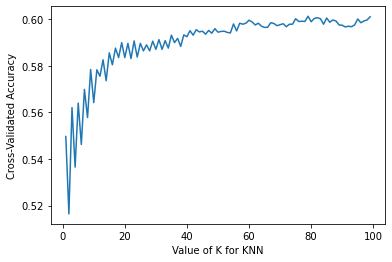

In [103]:
plt.plot(list(range(1, 100)),
         pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy');

In [104]:
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)

Best params:  {'n_neighbors': 79, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=79)
Best score:  0.6013918629550321


In [940]:
#Standardize
X = df_train[['left_batter','day_game', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball',
              's_1', 's_2', 'after_4_inning', 'last_contact', 'last_pa_so','ahead',
              'last_pa_long']]
y = df_train['fastball']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [977]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_scaled, y)
metrics.accuracy_score(y, knn.predict(X_scaled))

0.6455583303603282

In [978]:
cv_score =  cross_val_score(knn, X_scaled, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.58404711 0.55299786 0.58083512 0.55353319 0.56316916]


0.5669164882226981

In [974]:
knn = KNeighborsClassifier(n_neighbors=68)
knn.fit(X_scaled, y)
metrics.accuracy_score(y, knn.predict(X_scaled))

0.6252229753835177

In [975]:
cv_score =  cross_val_score(knn, X_scaled, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.61884368 0.58672377 0.61134904 0.57655246 0.62633833]


0.6039614561027837

In [947]:
knn_grid = GridSearchCV(knn, dict(n_neighbors=list(range(1, 200)), 
                        weights=['uniform', 'distance']), cv=tscv, scoring='accuracy')

In [948]:
knn_grid.fit(X_scaled, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsClassifier(n_neighbors=79),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [949]:
pd.DataFrame(knn_grid.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.051027,0.042737,0.165706,0.059961,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.552998,0.548715,0.554069,0.543362,0.563169,0.552463,0.006548,391
1,0.057198,0.041268,0.117323,0.060116,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.552998,0.548715,0.554069,0.543362,0.563169,0.552463,0.006548,391
2,0.048268,0.036881,0.143758,0.025097,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.505889,0.530514,0.519272,0.517131,0.524090,0.519379,0.008164,398
3,0.046766,0.037274,0.088991,0.032758,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.521949,0.541221,0.523019,0.525161,0.532120,0.528694,0.007195,397
4,0.052230,0.041295,0.154632,0.046369,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.552463,0.549786,0.572805,0.550321,0.561028,0.557281,0.008751,388


In [950]:
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:]

,mean_test_score
0,0.552463
2,0.519379
4,0.557281
6,0.541006
8,0.566916
...,...
388,0.598501
390,0.599358
392,0.599143
394,0.598501


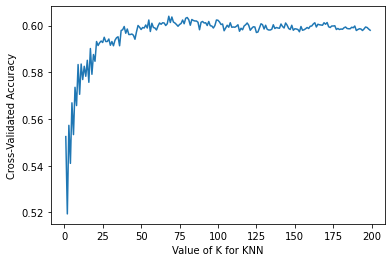

In [972]:
plt.plot(list(range(1, 200)),
         pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy');

In [973]:
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)

Best params:  {'n_neighbors': 68, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=68)
Best score:  0.6039614561027837


## KNN-different features

In [1692]:
df_train.columns

Index(['pitch_type', 'fastball', 'start_speed', 'zone', 'code', 'type',
       'b_score', 'p_score', 'ab_id', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'event', 'inning', 'left_batter',
       'top', 'weather', 'start_time', 'year', 'day_game', 'b_0', 'b_1', 'b_2',
       'b_3', 's_0', 's_1', 's_2', 'o_0', 'o_1', 'o_2', 'after_4_inning',
       'after_5_inning', 'first2ball', 'abs_diff', 'diff', 'tie', 'ahead',
       'behind', 'tempature', 'more_than_70', 'last_pitch_type',
       'last_fastball', 'last_code', 'last_type', 'last_b', 'last_s',
       'last_inplay', 'last_contact', 'last_pitch', 'last_pa', 'last_num',
       'game_pitch', 'last_over_8', 'over_30_pitches', 'last_pa_homerun',
       'last_pa_double_triple', 'last_pa_long', 'last_pa_so', 'last_pa_bb',
       'last_pa_dp', 'last_pa_out'],
      dtype='object')

In [1693]:
#Standardize
X = df_train[['left_batter','top', 'day_game', 'b_1', 'b_2', 'b_3',
              's_1', 's_2', 'o_1', 'o_2', 'after_4_inning', 'tie', 'ahead','behind', 'more_than_70',
              'last_fastball', 'last_b', 'last_s','last_inplay', 'last_contact', 
              'last_pa_homerun', 'last_pa_double_triple', 'last_pa_so', 'last_pa_bb','last_pa_dp', 'last_pa_out']]
y = df_train['fastball']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [1694]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_scaled, y)
metrics.accuracy_score(y, knn.predict(X_scaled))

0.8719229397074563

In [1695]:
knn.predict_proba(X)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [320]:
cv_score =  cross_val_score(knn, X_scaled, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.55835118 0.54657388 0.54710921 0.53586724 0.56477516]


0.5505353319057816

In [329]:
knn = KNeighborsClassifier(n_neighbors=89)
knn.fit(X_scaled, y)
metrics.accuracy_score(y, knn.predict(X_scaled))

0.6175526221905102

In [330]:
cv_score =  cross_val_score(knn, X_scaled, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.61295503 0.58672377 0.61134904 0.56263383 0.60385439]


0.5955032119914347

In [323]:
knn_grid = GridSearchCV(knn, dict(n_neighbors=list(range(1, 100)), 
                        weights=['uniform', 'distance']), cv=tscv, scoring='accuracy')

In [324]:
knn_grid.fit(X_scaled, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsClassifier(n_neighbors=67),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [325]:
pd.DataFrame(knn_grid.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002599,0.000585,0.251517,0.099024,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.558351,0.546574,0.547109,0.535867,0.564775,0.550535,0.010064,193
1,0.001788,0.000404,0.163386,0.070647,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.558351,0.546574,0.547109,0.535867,0.564775,0.550535,0.010064,193
2,0.001789,0.000372,0.237851,0.117081,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.498929,0.512313,0.519807,0.497323,0.503747,0.506424,0.008485,198
3,0.001958,0.000440,0.176542,0.076641,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.546574,0.538009,0.538544,0.520343,0.544433,0.537580,0.009231,196
4,0.002055,0.000425,0.301039,0.083238,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.565310,0.555675,0.566916,0.541756,0.572270,0.560385,0.010746,187


In [326]:
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:]

,mean_test_score
0,0.550535
2,0.506424
4,0.560385
6,0.532227
8,0.564989
...,...
188,0.592291
190,0.590578
192,0.590899
194,0.591542


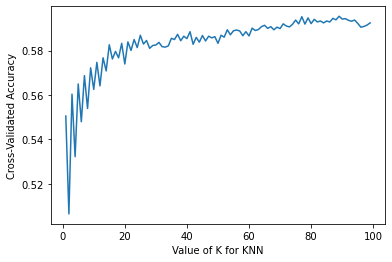

In [327]:
plt.plot(list(range(1, 100)),
         pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy');

In [328]:
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)

Best params:  {'n_neighbors': 89, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=89)
Best score:  0.5955032119914347


# KNN - pitch type

In [381]:
#Standardize
X = df_train[['b_count', 's_2', 'on_2b', 'on_3b', 'inning', 'left_batter',
       'day_game', 'ahead', 'behind', 'tempature','last_fastball','last_b','last_s', 'last_pa_homerun']]
y = df_train['pitch_type']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [382]:
X_scaled

array([[-0.84876287, -0.71316997, -0.38004206, ..., -0.67087823,
        -1.07139755, -0.16665903],
       [-0.84876287, -0.71316997, -0.38004206, ..., -0.67087823,
         0.93336035, -0.16665903],
       [-0.84876287,  1.40219027, -0.38004206, ..., -0.67087823,
         0.93336035, -0.16665903],
       ...,
       [ 0.23670871,  1.40219027, -0.38004206, ..., -0.67087823,
         0.93336035, -0.16665903],
       [ 1.32218029,  1.40219027, -0.38004206, ...,  1.49058347,
        -1.07139755, -0.16665903],
       [-0.84876287, -0.71316997, -0.38004206, ..., -0.67087823,
        -1.07139755, -0.16665903]])

In [383]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_scaled, y)
metrics.accuracy_score(y, knn.predict(X_scaled))

0.881377095968605

In [384]:
cv_score =  cross_val_score(knn, X_scaled, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.46466809 0.45770878 0.44539615 0.39453961 0.40417559]


0.4332976445396145

In [385]:
knn = KNeighborsClassifier(n_neighbors=63)
knn.fit(X_scaled, y)
metrics.accuracy_score(y, knn.predict(X_scaled))

0.555833036032822

In [386]:
cv_score =  cross_val_score(knn, X_scaled, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.60331906 0.54550321 0.55192719 0.44432548 0.50535332]


0.5300856531049251

In [161]:
knn_grid = GridSearchCV(knn, dict(n_neighbors=list(range(1, 100)), 
                        weights=['uniform', 'distance']), cv=tscv, scoring='accuracy')

In [162]:
knn_grid.fit(X_scaled, y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsClassifier(n_neighbors=79),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [163]:
pd.DataFrame(knn_grid.cv_results_).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.060837,0.035967,0.141836,0.033862,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.464668,0.457709,0.445396,0.394540,0.404176,0.433298,0.028554,195
1,0.054726,0.040503,0.075505,0.024178,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.464668,0.457709,0.445396,0.394540,0.404176,0.433298,0.028554,195
2,0.056149,0.047111,0.132332,0.027491,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",0.435760,0.423983,0.405246,0.351713,0.364026,0.396146,0.032964,198
3,0.052666,0.040997,0.084049,0.030238,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",0.456103,0.453426,0.437366,0.385439,0.389722,0.424411,0.030777,197
4,0.055605,0.044818,0.141446,0.031440,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.490899,0.482334,0.449143,0.397216,0.398822,0.443683,0.039811,194


In [164]:
pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:]

,mean_test_score
0,0.433298
2,0.396146
4,0.443683
6,0.462741
8,0.469593
...,...
188,0.523769
190,0.524411
192,0.523662
194,0.524732


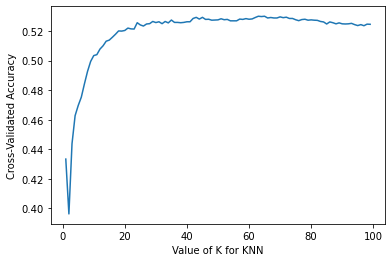

In [165]:
plt.plot(list(range(1, 100)),
         pd.DataFrame(knn_grid.cv_results_)[['mean_test_score','param_n_neighbors']].iloc[::2,0:1:])
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy');

In [166]:
print("Best params: ", knn_grid.best_params_)
print("Best estimator: ", knn_grid.best_estimator_)
print("Best score: ", knn_grid.best_score_)

Best params:  {'n_neighbors': 63, 'weights': 'uniform'}
Best estimator:  KNeighborsClassifier(n_neighbors=63)
Best score:  0.5300856531049251


## tree

In [991]:
X = df_train[['b_count', 's_2', 'on_2b', 'on_3b', 'inning', 'left_batter',
       'day_game', 'ahead', 'behind', 'tempature','last_fastball','last_b','last_s', 'last_pa_homerun']]
y = df_train['fastball']

In [992]:
randomforest = RandomForestClassifier(n_estimators=200, max_features='log2')
randomforest.fit(X, y)
randomforest.score(X,y)

0.9110774170531574

In [993]:
cv_score = cross_val_score(randomforest, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.57012848 0.57869379 0.57655246 0.55085653 0.56798715]


0.5688436830835117

In [997]:
X = df_train[['left_batter','day_game', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball',
              's_1', 's_2', 'after_4_inning', 'last_contact', 'last_pa_so','ahead',
              'last_pa_long']]
y = df_train['fastball']

In [998]:
randomforest = RandomForestClassifier(n_estimators=400)
randomforest.fit(X, y)
randomforest.score(X,y)

0.6863182304673564

In [999]:
cv_score = cross_val_score(randomforest, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.5754818  0.56905782 0.59743041 0.55995717 0.59154176]


0.578693790149893

In [1189]:
X = df_train[['b_count', 's_count','outs', 'on_1b', 'on_2b', 'on_3b', 'left_batter', 'last_num',
              'top', 'day_game', 'ahead', 'behind','last_fastball', 'last_b', 'tempature','diff','inning', 
              'last_s', 'last_pa_so',  'last_pa_out']]
y = df_train['fastball']

In [1190]:
randomforest = RandomForestClassifier(n_estimators=400, max_features='auto')
randomforest.fit(X, y)
randomforest.score(X,y)

0.9828754905458438

In [1191]:
cv_score = cross_val_score(randomforest, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.5990364  0.58672377 0.59368308 0.5637045  0.59100642]


0.586830835117773

In [1192]:
randomforest.feature_importances_

array([0.07572039, 0.06689632, 0.06366598, 0.02378312, 0.01689357,
       0.01206173, 0.02571355, 0.12224679, 0.03421249, 0.03243723,
       0.01552929, 0.01396557, 0.03277732, 0.02285091, 0.17126919,
       0.08634932, 0.10959218, 0.0255326 , 0.02825543, 0.02024701])

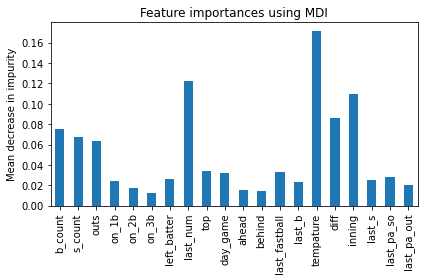

In [1193]:
forest_importances = pd.Series(randomforest.feature_importances_, index=X.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout();

<AxesSubplot:ylabel='feature'>

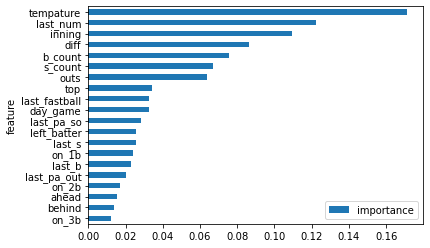

In [1194]:
feat_imps = list(zip(X.columns,randomforest.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')

In [271]:
feat_imps.sort_index(ascending=False)

,feature,importance
18,tempature,0.214631
17,inning,0.135693
16,diff,0.098458
15,b_count,0.077225
14,outs,0.076910
13,s_count,0.065550
12,top,0.039357
11,day_game,0.036565
10,last_fastball,0.034721
9,last_pa_so,0.033708


In [1102]:
X = df_train[['on_1b', 'on_2b', 'on_3b', 'left_batter',
       'top','day_game', 'b_1', 'b_2', 'b_3',
       's_1', 's_2', 'o_1', 'o_2', 'after_4_inning',
       'first2ball', 'tie', 'ahead', 'behind','more_than_70', 'last_fastball', 
       'last_b', 'last_contact','last_s',
       'last_pa_long', 'last_pa_so', 'last_pa_out']]
y = df_train['fastball']

In [1103]:
randomforest = RandomForestClassifier(n_estimators=300, max_features='auto')
randomforest.fit(X, y)
randomforest.score(X,y)

0.9019800214056368

In [1104]:
cv_score = cross_val_score(randomforest, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.59154176 0.58190578 0.58511777 0.5487152  0.58511777]


0.5784796573875803

<AxesSubplot:ylabel='feature'>

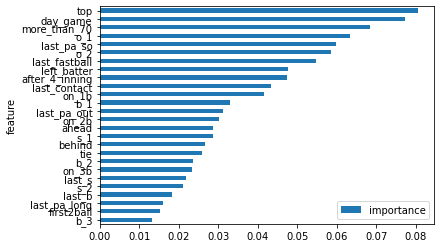

In [1100]:
feat_imps = list(zip(X.columns,randomforest.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')

In [1101]:
rfc = RandomForestClassifier() 
param_grid = {'n_estimators': list(range(50,501,50)),'max_features': ['auto', 'sqrt', 'log2']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=tscv)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)

{'max_features': 'auto', 'n_estimators': 300}


In [433]:
pd.DataFrame(CV_rfc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.310565,0.113226,0.022534,0.003089,auto,50,"{'max_features': 'auto', 'n_estimators': 50}",0.599036,0.583512,0.584047,0.554604,0.581370,0.580514,0.014399,10
1,0.619333,0.167396,0.058764,0.033853,auto,100,"{'max_features': 'auto', 'n_estimators': 100}",0.591006,0.582976,0.580835,0.564240,0.592612,0.582334,0.010109,7
2,1.372577,0.759921,0.093591,0.032799,auto,200,"{'max_features': 'auto', 'n_estimators': 200}",0.593683,0.596360,0.582976,0.559422,0.583512,0.583191,0.013028,5
3,2.966293,1.058058,0.215345,0.063936,auto,400,"{'max_features': 'auto', 'n_estimators': 400}",0.597430,0.591006,0.594218,0.561563,0.587259,0.586296,0.012818,2
4,0.347618,0.195025,0.030936,0.014767,sqrt,50,"{'max_features': 'sqrt', 'n_estimators': 50}",0.592077,0.577623,0.592612,0.558887,0.592077,0.582655,0.013168,6
5,0.751442,0.271762,0.061861,0.027751,sqrt,100,"{'max_features': 'sqrt', 'n_estimators': 100}",0.594754,0.584047,0.590471,0.547645,0.582976,0.579979,0.016730,11
6,1.344366,0.568938,0.095336,0.026940,sqrt,200,"{'max_features': 'sqrt', 'n_estimators': 200}",0.595289,0.579764,0.587259,0.554069,0.588865,0.581049,0.014367,9
7,2.671186,0.748278,0.214334,0.060014,sqrt,400,"{'max_features': 'sqrt', 'n_estimators': 400}",0.598501,0.586188,0.589936,0.554604,0.589936,0.583833,0.015163,4
8,0.351715,0.220202,0.021495,0.002111,log2,50,"{'max_features': 'log2', 'n_estimators': 50}",0.587794,0.584582,0.579764,0.555139,0.582441,0.577944,0.011702,12
9,0.718826,0.255056,0.067445,0.038417,log2,100,"{'max_features': 'log2', 'n_estimators': 100}",0.598501,0.589400,0.593148,0.553533,0.586724,0.584261,0.015865,3


In [1291]:
df_train.columns

Index(['pitch_type', 'fastball', 'start_speed', 'zone', 'code', 'type',
       'b_score', 'p_score', 'ab_id', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'event', 'inning', 'left_batter',
       'top', 'weather', 'start_time', 'year', 'day_game', 'b_0', 'b_1', 'b_2',
       'b_3', 's_0', 's_1', 's_2', 'o_0', 'o_1', 'o_2', 'after_4_inning',
       'after_5_inning', 'first2ball', 'abs_diff', 'diff', 'tie', 'ahead',
       'behind', 'tempature', 'more_than_70', 'last_pitch_type',
       'last_fastball', 'last_code', 'last_type', 'last_b', 'last_s',
       'last_inplay', 'last_contact', 'last_pitch', 'last_pa', 'last_num',
       'game_pitch', 'last_over_8', 'over_30_pitches', 'last_pa_homerun',
       'last_pa_double_triple', 'last_pa_long', 'last_pa_so', 'last_pa_bb',
       'last_pa_dp', 'last_pa_out'],
      dtype='object')

In [1292]:
X = df_train[['b_score', 'p_score', 'pitch_num', 'b_count', 's_count',
       'outs', 'on_1b', 'on_2b', 'on_3b', 'inning', 'left_batter',
       'top', 'day_game', 'b_0', 'b_1', 'b_2','b_3', 's_0', 's_1', 's_2', 'o_0', 'o_1', 'o_2', 
       'after_4_inning', 'after_5_inning','first2ball', 'abs_diff', 'diff', 'tie', 'ahead', 'behind', 
       'tempature','more_than_70', 'last_fastball', 'last_b', 'last_s', 'last_inplay', 'last_contact',
       'last_num', 'game_pitch', 'last_over_8','over_30_pitches', 'last_pa_homerun', 'last_pa_double_triple',
       'last_pa_long', 'last_pa_so', 'last_pa_bb', 'last_pa_dp','last_pa_out']]
y = df_train['fastball']

In [1293]:
randomforest = RandomForestClassifier(n_estimators=250, max_features='log2')
randomforest.fit(X, y)
randomforest.score(X,y)

0.999910809846593

In [1294]:
cv_score = cross_val_score(randomforest, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.60653105 0.59154176 0.58297645 0.55835118 0.59421842]


0.5867237687366167

<AxesSubplot:ylabel='feature'>

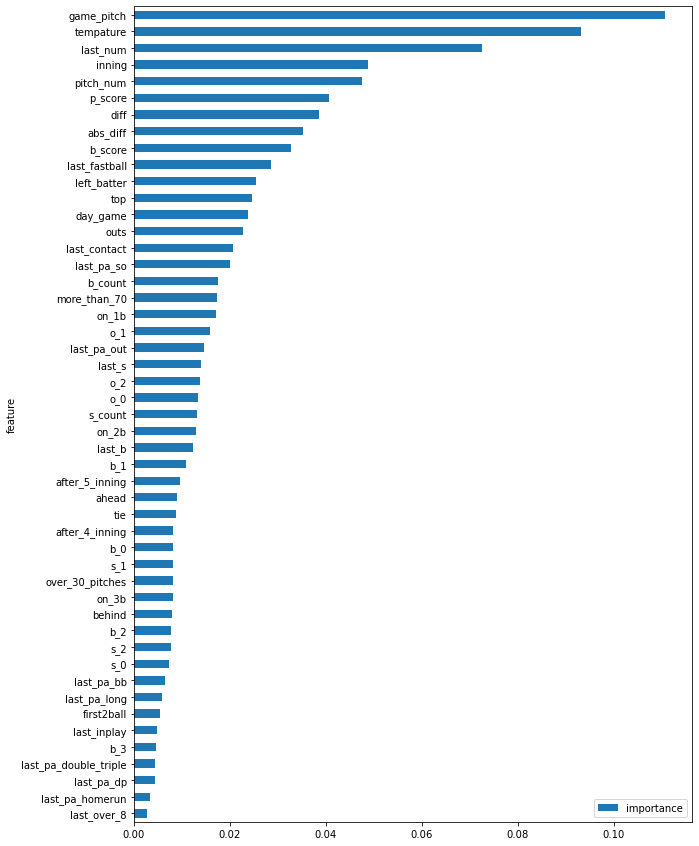

In [1295]:
feat_imps = list(zip(X.columns,randomforest.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh',figsize=(10,15))

In [1271]:
rfc = RandomForestClassifier() 
param_grid = {'n_estimators': list(range(50,501,50)),'max_features': ['auto', 'sqrt', 'log2']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=tscv)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)

{'max_features': 'log2', 'n_estimators': 250}


In [1307]:
X = df_train[['on_1b', 'on_2b', 'on_3b', 'left_batter','top', 'day_game', 'b_0','b_1', 'b_2', 'b_3',
              's_0', 's_1', 's_2', 'o_0', 'o_1', 'o_2', 'after_4_inning', 'after_5_inning','first2ball', 
              'tie', 'ahead', 'behind', 'more_than_70', 'last_fastball', 'last_b', 'last_s', 'last_inplay', 
              'last_contact','last_over_8','over_30_pitches', 'last_pa_homerun', 'last_pa_double_triple',
              'last_pa_long', 'last_pa_so', 'last_pa_bb', 'last_pa_dp','last_pa_out']]
y = df_train['fastball']

In [1308]:
randomforest = RandomForestClassifier(n_estimators=500, max_features='log2')
randomforest.fit(X, y)
randomforest.score(X,y)

0.9283803068141278

In [1309]:
cv_score = cross_val_score(randomforest, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.59047109 0.58029979 0.57815846 0.54925054 0.57976445]


0.5755888650963599

<AxesSubplot:ylabel='feature'>

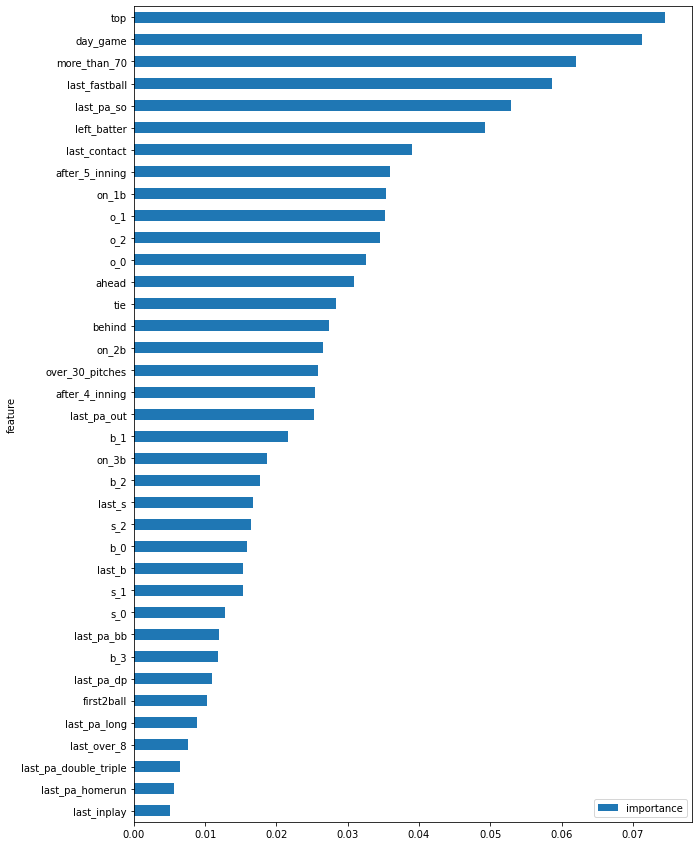

In [1310]:
feat_imps = list(zip(X.columns,randomforest.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh',figsize=(10,15))

In [1305]:
rfc = RandomForestClassifier() 
param_grid = {'n_estimators': list(range(50,501,50)),'max_features': ['sqrt', 'log2']}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=tscv)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)

{'max_features': 'log2', 'n_estimators': 500}


In [1705]:
X = df_train[['on_1b', 'on_2b', 'on_3b', 'left_batter','top', 'day_game', 'b_0','b_1', 'b_2', 'b_3',
              's_0', 's_1', 's_2', 'o_0', 'o_1', 'o_2', 'after_4_inning', 'after_5_inning','first2ball', 
              'tie', 'ahead', 'behind', 'more_than_70', 'last_fastball', 'last_b', 'last_s', 'last_inplay', 
              'last_contact','last_over_8','over_30_pitches', 'last_pa_homerun', 'last_pa_double_triple',
              'last_pa_long', 'last_pa_so', 'last_pa_bb', 'last_pa_dp','last_pa_out']]
y = df_train['fastball']

In [1706]:
randomforest = RandomForestClassifier(n_estimators=500, max_features='auto', max_depth=6)
randomforest.fit(X, y)
randomforest.score(X,y)

0.6267392079914378

In [1707]:
randomforest.predict_proba(X)

array([[0.23928047, 0.76071953],
       [0.29899289, 0.70100711],
       [0.44210257, 0.55789743],
       ...,
       [0.58754013, 0.41245987],
       [0.55096192, 0.44903808],
       [0.42402257, 0.57597743]])

In [1708]:
cv_score = cross_val_score(randomforest, X, y,cv=tscv, scoring='accuracy')
print(cv_score)
cv_score.mean()

[0.61777302 0.60546039 0.61509636 0.57601713 0.64293362]


0.6114561027837259

<AxesSubplot:ylabel='feature'>

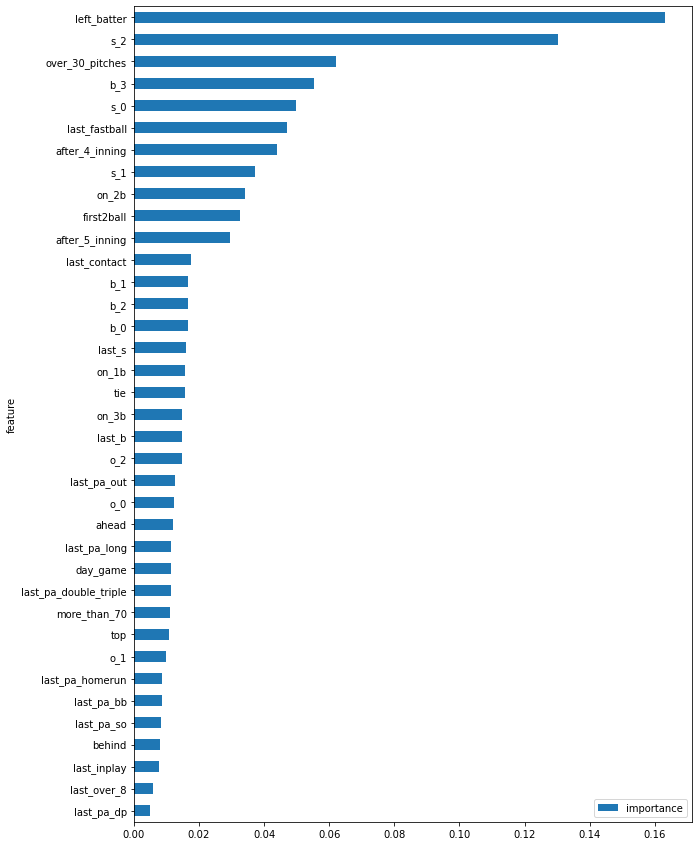

In [1709]:
feat_imps = list(zip(X.columns,randomforest.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh',figsize=(10,15))

In [1700]:
rfc = RandomForestClassifier() 
param_grid = {'n_estimators': [500],'max_features': ['sqrt', 'log2'],
              'max_depth': list(range(2,7,1))}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=tscv)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)


{'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 500}


In [1698]:
rfc = RandomForestClassifier() 
param_grid = {'n_estimators': [500],'max_features': ['sqrt', 'log2'],
              'max_depth': list(range(7,20,1))}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=tscv)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)


{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 500}


In [1688]:
CV_rfc.best_score_

0.6110278372591006

## Other

In [1543]:
for train_index, test_index in tscv.split(df_clean):
    print(train_index, test_index)

[   0    1    2 ... 2241 2242 2243] [2244 2245 2246 ... 4483 4484 4485]
[   0    1    2 ... 4483 4484 4485] [4486 4487 4488 ... 6725 6726 6727]
[   0    1    2 ... 6725 6726 6727] [6728 6729 6730 ... 8967 8968 8969]
[   0    1    2 ... 8967 8968 8969] [ 8970  8971  8972 ... 11209 11210 11211]
[    0     1     2 ... 11209 11210 11211] [11212 11213 11214 ... 13451 13452 13453]


In [1572]:
df_train_weighted = pd.concat([df_train.iloc[range(0,2244)],
                                df_train.iloc[range(2244,4486)], df_train.iloc[range(2244,4486)],
                                df_train.iloc[range(4486,6728)], df_train.iloc[range(4486,6728)], df_train.iloc[range(4486,6728)],
                                df_train.iloc[range(6728,8970)], df_train.iloc[range(6728,8970)],
                                df_train.iloc[range(6728,8970)], df_train.iloc[range(6728,8970)]])
df_train_weighted.sort_values(by = ['ab_id', 'pitch_num'], inplace = True)
df_train_weighted

,pitch_type,fastball,start_speed,zone,code,type,b_score,p_score,ab_id,pitch_num,...,game_pitch,last_over_8,over_30_pitches,last_pa_homerun,last_pa_double_triple,last_pa_long,last_pa_so,last_pa_bb,last_pa_dp,last_pa_out
0,FF,1,90.6,13.0,C,S,0,0,2015000632,1,...,0,0,0,0,0,0,1,0,0,1
1,FF,1,93.5,11.0,F,S,0,0,2015000632,2,...,0,0,0,0,0,0,1,0,0,1
2,FF,1,94.9,11.0,B,B,0,0,2015000632,3,...,0,0,0,0,0,0,1,0,0,1
3,CH,0,86.6,14.0,B,B,0,0,2015000632,4,...,0,0,0,0,0,0,1,0,0,1
4,FF,1,94.0,11.0,B,B,0,0,2015000632,5,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9002,FT,1,92.4,11.0,B,B,5,0,2017110216,1,...,55,0,1,0,0,0,0,0,0,1
9003,CU,0,76.0,1.0,F,S,5,0,2017110216,2,...,55,0,1,0,0,0,0,0,0,1
9003,CU,0,76.0,1.0,F,S,5,0,2017110216,2,...,55,0,1,0,0,0,0,0,0,1
9003,CU,0,76.0,1.0,F,S,5,0,2017110216,2,...,55,0,1,0,0,0,0,0,0,1


In [1366]:
def class_cv(X_score, y_score, cv_score, mertic_score):
    '''
    A function to run scores on classificaiton models
    Slow on KNN and RandomForestClassifier
    '''
    scaler_s = StandardScaler()
    X_scaled_s = scaler_s.fit_transform(X_score)
    
    log_reg_s = LogisticRegression(penalty='none')
    cv_score_log = cross_val_score(log_reg_s, X_score, y_score, cv=cv_score, scoring=mertic_score)
    print('Logistic Regression without peanlty:', cv_score_log, cv_score_log.mean())
    
    log_grid_s = GridSearchCV(log_reg_s, 
                              param_grid={'C':[0.001,0.01,0.1,1,10,100,1000,10000],'penalty': ['l1','l2','none'],
                                          'solver': ['liblinear']}, 
                              cv=cv_score, scoring=mertic_score)
    log_grid_s.fit(X_scaled_s, y_score)
    print('Logistic Regression grid search:', log_grid_s.best_score_, log_grid_s.best_params_)
    
    knn_s = KNeighborsClassifier()
    knn_grid_s = GridSearchCV(knn_s, 
                              param_grid={'n_neighbors': list(range(1, 100)),
                                          'weights': ['uniform', 'distance']},
                              cv=cv_score, scoring=mertic_score)
    knn_grid_s.fit(X_scaled_s, y_score)
    print('KNN grid search:', knn_grid_s.best_score_, knn_grid_s.best_params_)
    
    rfc_s = RandomForestClassifier() 
    rfc_grid_s = GridSearchCV(rfc_s, 
                          param_grid={'n_estimators': list(range(50,501,50)),
                                      'max_features': ['sqrt', 'log2']}, 
                          cv=cv_score, scoring=mertic_score)
    rfc_grid_s.fit(X_score, y_score)
    print('RandomForestClassifier grid search:', rfc_grid_s.best_score_, rfc_grid_s.best_params_)
    pass
    

In [1365]:
X = df_train[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball',
              's_1', 's_2', 'after_4_inning', 'last_contact','day_game', 'last_pa_so','ahead','last_pa_long']]
y = df_train['fastball']
class_cv(X, y, tscv, 'accuracy')

Logistic Regression without peanlty: [0.63008565 0.60171306 0.62152034 0.58672377 0.62740899] 0.6134903640256959
Logistic Regression grid search: 0.6137044967880086 {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
KNN grid search: 0.6039614561027837 {'n_neighbors': 68, 'weights': 'uniform'}
RandomForestClassifier grid search: 0.5808351177730193 {'max_features': 'sqrt', 'n_estimators': 450}


In [1542]:
X = df_train[['left_batter', 'b_1', 'b_2', 'b_3', 'last_b','last_fastball',
              's_1', 's_2', 'after_4_inning', 'last_contact','day_game', 'last_pa_so','ahead','last_pa_long']]
y = df_train['fastball']
class_cv(X, y, 5, 'accuracy')

Logistic Regression without peanlty: [0.62104325 0.59741418 0.6235504  0.61552186 0.60080285] 0.6116665069203305
Logistic Regression grid search: 0.6130934858095539 {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
KNN grid search: 0.6093463537865649 {'n_neighbors': 89, 'weights': 'uniform'}
RandomForestClassifier grid search: 0.5842845001378061 {'max_features': 'log2', 'n_estimators': 450}
